<a href="https://colab.research.google.com/github/Zasegor/fourier-series-prediction/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import numpy as np
import pandas as pd
from scipy.signal import find_peaks
from statsmodels.tsa.stattools import acf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import plotly.graph_objects as go


---

In [ ]:
class FourierForecaster:
    """
    A class for forecasting time series using Fourier series with cosine terms.

    Args:
        l (int): Length of the period.
        m (int): Number of periods.
        p (int): Delay size for 'delay' method or AR order for 'arima' method.
        method (str): Forecasting method ('delay' for delay matrix or 'arima' for ARIMA).
        reg_lambda (float): Regularization parameter for solving linear systems.
    """
    def __init__(self, l: int, m: int, p: int = 1, method: str = "delay", reg_lambda: float = 1e-6):
        self.l = l
        self.m = m
        self.p = p
        self.method = method.lower()
        self.reg_lambda = reg_lambda
        self.matrix = None
        self.new_coefs = None
        self.prediction = None

        if self.method not in ["delay", "arima"]:
            raise ValueError("Method must be 'delay' or 'arima'")
        if self.l < 1 or self.m < 1 or self.p < 1:
            raise ValueError("l, m, and p must be positive integers")

    def _cos(self, k: int, t: int, l: int) -> float:
        """Computes the cosine term for Fourier series."""
        return math.cos(math.pi * k * t / l)

    def _get_matrix_and_vector(self, period_i: np.ndarray) -> tuple[np.ndarray, np.ndarray]:
        """Constructs the matrix and vector for Fourier coefficient computation."""
        if len(period_i) < 2:
            raise ValueError("period_i must have at least 2 elements")

        l = len(period_i) - 1
        t = np.arange(l + 1)
        k = np.arange(1, l + 1)

        cos_values = np.cos(np.pi * k[:, None] * t / l)
        matrix = np.hstack([0.5 * np.ones((l + 1, 1)), cos_values.T])
        y = period_i.copy()

        return matrix, y

    def _solve_system(self, M: np.ndarray, b: np.ndarray) -> np.ndarray:
        """Solves a linear system with optional regularization."""
        if np.linalg.cond(M) > 1e6:
            M_reg = M + self.reg_lambda * np.eye(M.shape[0])
            return np.linalg.solve(M_reg, b)
        return np.linalg.solve(M, b)

    def _get_matrix_from_series(self, series: pd.Series) -> np.ndarray:
        """Converts the time series into a matrix of period observations."""
        expected_length = self.m * self.l
        if len(series) < expected_length:
            raise ValueError(f"Series length {len(series)} is less than required {expected_length}")

        series_values = series.values[:expected_length]
        if len(series_values) < expected_length:
            series_values = np.pad(series_values, (0, expected_length - len(series_values)), mode='constant')

        return series_values.reshape(self.m, self.l)

    def _get_delay_matrix(self, input_vector: np.ndarray) -> np.ndarray:
        """Constructs a delay matrix for k-NN forecasting."""
        input_vector_copy = np.copy(input_vector)
        m = input_vector_copy.shape[0] % self.p

        if m != 0:
            input_vector_copy = np.delete(input_vector_copy, range(m))

        row_dim = input_vector_copy.shape[0] // self.p
        delay_matrix = np.resize(input_vector_copy, new_shape=(row_dim, self.p)).T

        return delay_matrix

    def _find_nearest(self, row: np.ndarray) -> set:
        """Finds indices of nearest neighbors for k-NN forecasting."""
        neighbors_cnt = 2 * self.p + 1
        last_element = row[-1]
        all_neighbors = row[:-1]
        idx = set(np.argsort(np.abs(all_neighbors - last_element))[:neighbors_cnt])

        return idx

    def _predict_by_one_step(self, input_vector: np.ndarray) -> float:
        """Predicts one step ahead using the specified method."""
        if self.method == "arima":
            if len(input_vector) < 3:
                return input_vector[-1]
            try:
                model = ARIMA(input_vector, order=(min(self.p, 2), 0, 0))
                model_fit = model.fit()
                return model_fit.forecast(steps=1)[0]
            except Exception:
                return input_vector[-1]
        else:  # delay method
            delay_matrix = self._get_delay_matrix(input_vector)
            last_row = delay_matrix[-1, :]
            nearest_neighbors_indexes = self._find_nearest(last_row)

            y = np.empty((0,))
            X = np.empty((0, self.p + 1))
            for index in nearest_neighbors_indexes:
                y = np.append(y, delay_matrix[0, index + 1])
                row = np.append(np.array([1]), delay_matrix[:, index])
                row = np.reshape(row, (1, self.p + 1))
                X = np.append(X, row, axis=0)

            coef = np.dot(np.dot(np.linalg.inv(np.dot(X.T, X)), X.T), y)
            return sum(np.append(np.array([1]), delay_matrix[:, -1]) * coef)

    def _get_new_fourier_coefs(self, periods: np.ndarray) -> list:
        """Computes Fourier coefficients for the next period."""
        new_coefs = []
        coefs_for_all_periods = []

        for period in periods:
            X, y = self._get_matrix_and_vector(period)
            fourier_coef_for_period = self._solve_system(X, y)
            coefs_for_all_periods.append(fourier_coef_for_period)

        coefs_for_all_periods = np.array(coefs_for_all_periods)

        for i in range(coefs_for_all_periods.shape[1]):
            coef_for_next_period = self._predict_by_one_step(coefs_for_all_periods[:, i])
            new_coefs.append(coef_for_next_period)

        return new_coefs

    def _predict_next_period(self) -> list:
        """Predicts the time series for the next period."""
        new_period = []
        for t in range(self.l):
            s = self.new_coefs[0] / 2
            for k in range(1, len(self.new_coefs)):
                s += self.new_coefs[k] * self._cos(k, t, self.l - 1)
            new_period.append(s)

        return new_period

    def fit(self, series: pd.Series) -> 'FourierForecaster':
        """
        Fits the model to the input time series.

        Args:
            series: Input time series (pandas Series).

        Returns:
            Self for method chaining.
        """
        self.matrix = self._get_matrix_from_series(series)
        self.new_coefs = self._get_new_fourier_coefs(self.matrix)
        return self

    def predict(self, index: pd.Index = None) -> pd.Series:
        """
        Predicts the next period.

        Args:
            index: Index for the predicted series (optional).

        Returns:
            Predicted series for the next period (pandas Series).
        """
        self.prediction = self._predict_next_period()
        if index is None:
            index = pd.RangeIndex(start=0, stop=self.l)
        return pd.Series(self.prediction, index=index)

    def evaluate(self, test_series: pd.Series, end_date: str = None) -> tuple[float, float]:
        """
        Evaluates the prediction against a test series.

        Args:
            test_series: Test time series (pandas Series).
            end_date: End date for evaluation (optional, e.g., '2020-02-21').

        Returns:
            Tuple of (MAE, MAPE) metrics.
        """
        if self.prediction is None:
            raise ValueError("Model must be fitted and predicted before evaluation")

        pred = pd.Series(self.prediction[:min(self.l, len(test_series))], index=test_series.index[:min(self.l, len(test_series))])
        if end_date:
            pred = pred[pred.index <= pd.Timestamp(end_date)]
            test = test_series[test_series.index <= pd.Timestamp(end_date)]
        else:
            test = test_series[:self.l]

        mae = round(mean_absolute_error(test, pred), 2)
        mape = round(mean_absolute_percentage_error(test, pred), 3)
        return mae, mape

    def plot(self, test_series: pd.Series, end_date: str = None) -> go.Figure:
        """
        Plots the predicted and test series using Plotly.

        Args:
            test_series: Test time series (pandas Series).
            end_date: End date for plotting (optional, e.g., '2020-02-21').

        Returns:
            Plotly Figure object.
        """
        if self.prediction is None:
            raise ValueError("Model must be fitted and predicted before plotting")

        pred = pd.Series(self.prediction[:min(self.l, len(test_series))], index=test_series.index[:min(self.l, len(test_series))])
        if end_date:
            pred = pred[pred.index <= pd.Timestamp(end_date)]
            test = test_series[test_series.index <= pd.Timestamp(end_date)]
        else:
            test = test_series[:self.l]

        fig = go.Figure()
        fig.add_scatter(
            x=pred.index,
            y=pred.values,
            line={'width': 2},
            name="Pred"
        )
        fig.add_scatter(
            x=test.index,
            y=test.values,
            line={'width': 2},
            name="Test"
        )
        fig.update_layout(
            title="Fourier Forecast vs Test Data",
            xaxis_title="Date",
            yaxis_title="Value",
            template="plotly_white"
        )
        return fig

# Синтетические данные

In [ ]:
start_date = '2013-01-01'
dates = pd.date_range(start=start_date, periods=360*10, freq='D')
n_days = len(dates)

np.random.seed(42)
t = np.arange(n_days)

cycle1 = 50 * np.cos(2 * np.pi * t / 180)
cycle2 = 30 * np.cos(2 * np.pi * t / 360)

trend = 0.1 * t + 100

noise = np.random.normal(0, 10, n_days)

prices = trend + cycle1 + cycle2 + noise
prices = np.maximum(prices, 10)

series = pd.Series(prices, index=dates, name='price')

df = pd.DataFrame({'datetime': series.index, 'price': series.values})
df.to_csv('synthetic_prices.csv', index=False)

print(series.head())

2013-01-01    184.967142
2013-01-02    178.682329
2013-01-03    186.536813
2013-01-04    195.215279
2013-01-05    177.498791
Freq: D, Name: price, dtype: float64


In [ ]:
series = pd.Series(df['price'].values, index=pd.to_datetime(df['datetime']))

train_size = 360*9
train_series = series[:train_size]
test_series = series[train_size:]

In [ ]:
fig = go.Figure()

fig.add_scatter(
    x=train_series.index,
    y=train_series.values,
    line={'width':2},
    name="Train"
)

fig.add_scatter(
    x=test_series.index,
    y=test_series.values,
    line={'width':2},
    name="Test"
)

fig.update_layout(
    title='Предсказание погоды',
    scene=dict(
        xaxis_title='Дата',
        yaxis_title='oC'
    ),
    showlegend=True,
    height=600
)

In [ ]:
forecaster = FourierForecaster(l=360, m=9, p=2, method="arima")
forecaster.fit(train_series)

test_pred = forecaster.predict(index=test_series.index[:360])

mae, mape = forecaster.evaluate(test_series)
print(f"MAE: {mae}, MAPE: {mape}")

fig1 = forecaster.plot(test_series)
fig1.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



MAE: 10.62, MAPE: 0.024


In [ ]:
fig.add_scatter(
    x=test_pred.index,
    y=test_pred.values,
    line={'width':2},
    name="Pred"
)

# Погода

In [ ]:
data = pd.read_csv('/content/DailyDelhiClimateTrain.csv')[['date', 'meantemp']]
data['date'] = pd.to_datetime(data['date'])
test_data = pd.read_csv('/content/DailyDelhiClimateTest.csv')[['date', 'meantemp']]
test_data['date'] = pd.to_datetime(test_data['date'])

temp_series = data.set_index('date')['meantemp']
temp_series = temp_series[~((temp_series.index.month == 2) & (temp_series.index.day == 29))][:-1]
test_series = test_data.set_index('date')['meantemp']
test_series = test_series[~((test_series.index.month == 2) & (test_series.index.day == 29))]

In [ ]:
fig = go.Figure()

fig.add_scatter(
    x=temp_series.index,
    y=temp_series.values,
    line={'width':2},
    name="Train"
)

fig.add_scatter(
    x=test_series.index,
    y=test_series.values,
    line={'width':2},
    name="Test"
)

fig.update_layout(
    title='Предсказание погоды',
    scene=dict(
        xaxis_title='Дата',
        yaxis_title='oC'
    ),
    showlegend=True,
    height=600
)

In [ ]:
m = 4
l = 365
p = 1

index = pd.date_range("2017-01-01", "2017-12-31", freq="D")

forecaster = FourierForecaster(l=l, m=m, p=p, method="arima")
forecaster.fit(temp_series)

test_pred = forecaster.predict(index=index)

mae, mape = forecaster.evaluate(test_series)
print(f"MAE: {mae}, MAPE: {mape}")

fig1 = forecaster.plot(test_series)
fig1.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_ret

MAE: 2.56, MAPE: 0.118


/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



In [ ]:
fig.add_scatter(x=test_pred.index,
                y=test_pred.values,
                line={'width':2},
                name="Pred"
)

---

# Самолеты

In [ ]:
data = pd.read_csv('/content/euro_arrivals.csv')
data['FLT_DATE'] = pd.to_datetime(data['FLT_DATE'])

data_series = data.set_index('FLT_DATE')['FLT_ARR_1']
data_series = data_series[~((data_series.index.month == 2) & (data_series.index.day == 29))]

In [ ]:
[len(data_series[data_series.index.year == i]) for i in range(2016, 2025)]

[366, 365, 365, 365, 366, 365, 365, 365, 366]

In [ ]:
fig = go.Figure()

fig.add_scatter(
    x=data_series.index,
    y=data_series.values,
    line={'width':2},
    name="Data"
)

fig.update_layout(
    title='',
    scene=dict(
        xaxis_title='',
        yaxis_title=''
    ),
    showlegend=True,
    height=600
)

In [ ]:
train_series = data_series[data_series.index.year<=2019]
test_series = data_series[data_series.index.year==2020]
test_series = test_series[test_series.index<=pd.Timestamp('2020-02-21')]

In [ ]:
test_series.head()

,FLT_ARR_1
FLT_DATE,
2020-01-01,16056
2020-01-02,20778
2020-01-03,21282
2020-01-04,18666
2020-01-05,20757


In [ ]:
fig = go.Figure()

fig.add_scatter(
    x=train_series.index,
    y=train_series.values,
    line={'width':2},
    name="Train"
)

fig.update_layout(
    title='',
    scene=dict(
        xaxis_title='',
        yaxis_title=''
    ),
    showlegend=True,
    height=600
)

In [ ]:
m = 4
l = 365
p = 1

index = pd.date_range(start='2020-01-01', end='2020-12-31', freq='D')
index = index[~((index.month == 2) & (index.day == 29))]

forecaster = FourierForecaster(l=l, m=m, p=p)
forecaster.fit(train_series)

test_pred = forecaster.predict(index=index)

mae, mape = forecaster.evaluate(test_series, end_date='2020-02-21')
print(f"MAE: {mae}, MAPE: {mape}")

fig1 = forecaster.plot(test_series, end_date='2020-02-21')
fig1.show()

MAE: 1711.85, MAPE: 0.092


In [ ]:
forecaster_arima = FourierForecaster(l=l, m=m, p=p, method="arima")
forecaster_arima.fit(train_series)

test_pred_arima = forecaster_arima.predict(index=index)

mae, mape = forecaster_arima.evaluate(test_series, end_date='2020-02-21')
print(f"MAE: {mae}, MAPE: {mape}")

fig1 = forecaster_arima.plot(test_series, end_date='2020-02-21')
fig1.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.



MAE: 1720.51, MAPE: 0.089


In [ ]:
fig.add_scatter(
    x=test_pred.index,
    y=test_pred.values,
    line={'width':2},
    name="Pred"
)

fig.add_scatter(
    x=test_pred_arima.index,
    y=test_pred_arima.values,
    line={'width':2},
    name="PredArima"
)

fig.add_scatter(
    x=test_series.index,
    y=test_series.values,
    line={'width':2},
    name="Test"
)

---

# ЗП

<ipython-input-175-7b15c482f0b1>:5: UserWarning:

Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.



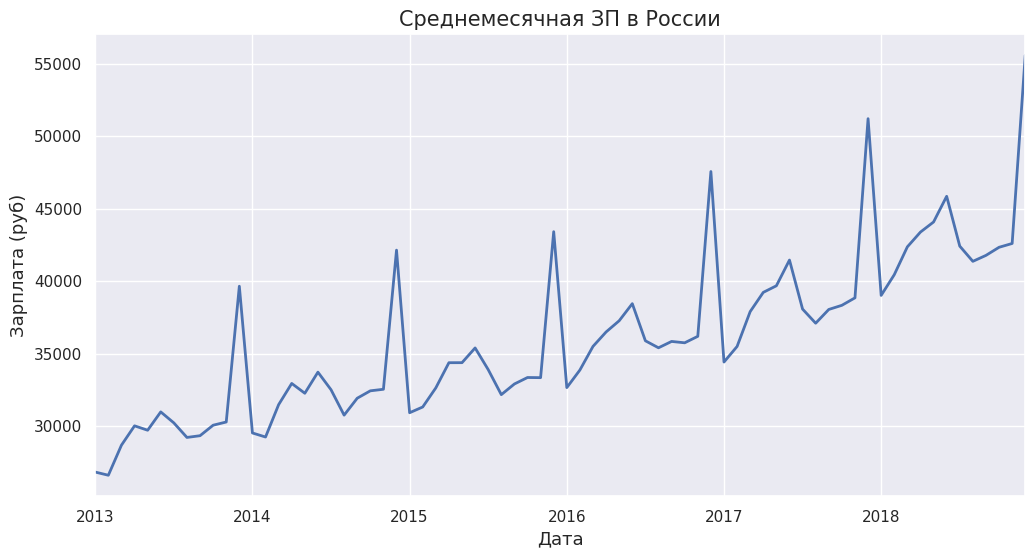

In [ ]:
data = pd.read_excel('/content/mean_salary.xlsx')

melted = data.melt(id_vars='year', var_name='month', value_name='salary')

melted['date'] = pd.to_datetime(melted['year'].astype(str) + '-' + melted['month'])
salary_series = melted.set_index('date')['salary'].sort_index()

train_series = salary_series[salary_series.index.year<2018]
test_series = salary_series[salary_series.index.year==2018]

plt.figure(figsize=(12, 6))
salary_series.plot(linewidth=2)
plt.title('Среднемесячная ЗП в России', fontsize=15)
plt.xlabel('Дата', fontsize=13)
plt.ylabel('Зарплата (руб)', fontsize=13)
plt.grid(True)
plt.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning:

Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_ret

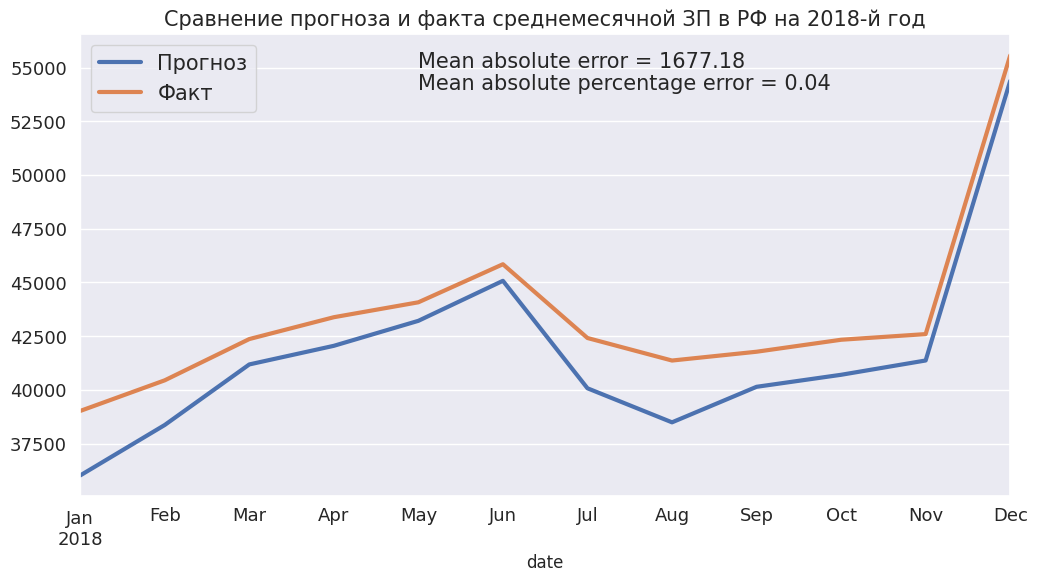

In [ ]:
m = 5 #количество периодов в train выборке
l = 12 #длина периода
p = 2 #величина задержек

matrix = get_matrix_from_series(train_series, m, l)
new_coefs = get_new_fourier_coefs(matrix, p)
test_pred = predict_next_period(new_coefs, l)
test_pred = pd.Series(test_pred, index=test_series.index)

#ошибка прогноза
mae = round(mean_absolute_error(test_pred, test_series), 2)
mape = round(mean_absolute_percentage_error(test_series, test_pred), 3)


#построим график
test_pred.plot(figsize=(12, 6), linewidth=3,
               fontsize=13, label='Прогноз')

test_series.plot(figsize=(12, 6), linewidth=3,
                 fontsize=13, label='Факт')

plt.legend(fontsize=15)
plt.text(test_series.index[4], 55000, f'Mean absolute error = {mae}', fontsize=15)
plt.text(test_series.index[4], 54000, f'Mean absolute percentage error = {mape}', fontsize=15)
plt.title('Сравнение прогноза и факта среднемесячной ЗП в РФ на 2018-й год', fontsize=15)
plt.show()

---

In [ ]:
data = pd.read_csv('/content/Climate Change Dataset.csv')
data['DATE'] = pd.to_datetime(data['DATE'])

data_series = data.set_index('DATE')['TempAVG']

In [ ]:
[len(data_series[data_series.index.year == i]) for i in range(2000, 2023)]

[361,
 365,
 353,
 338,
 356,
 360,
 363,
 362,
 366,
 363,
 365,
 360,
 366,
 365,
 365,
 365,
 366,
 365,
 365,
 365,
 366,
 362,
 365]

---

# ЭКГ-сигнал

In [ ]:
!pip install neurokit2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 693.1/693.1 kB 20.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
from scipy import signal
import neurokit2 as nk
from scipy.interpolate import interp1d

# Загрузка датасета
df = pd.read_csv('/content/ecg_1d_timeseries_prediction.csv', sep=';')

# Шаг 1: Ресемплирование до 200 Гц (шаг 0.005 секунды)
original_time = df['time'].values
ecg_signal = df['ecg_value'].values
original_dt = original_time[1] - original_time[0]  # 0.001 секунды
target_dt = 0.005  # 200 Гц
new_time = np.arange(original_time[0], original_time[-1], target_dt)
interp_func = interp1d(original_time, ecg_signal, kind='linear')
ecg_resampled = interp_func(new_time)

# Шаг 2: Сглаживание (фильтр Баттерворта 0.5–40 Гц)
fs = 1 / target_dt  # Частота дискретизации (200 Гц)
lowcut = 0.5  # Нижняя частота среза
highcut = 40  # Верхняя частота среза
nyquist = 0.5 * fs
low = lowcut / nyquist
high = highcut / nyquist
b, a = signal.butter(4, [low, high], btype='band')
ecg_filtered = signal.filtfilt(b, a, ecg_resampled)

# Шаг 3: Детекция R-пиков и сегментация
ecg_cleaned = nk.ecg_clean(ecg_filtered, sampling_rate=fs)
r_peaks = nk.ecg_peaks(ecg_cleaned, sampling_rate=fs)[1]['ECG_R_Peaks']
r_peaks = r_peaks[r_peaks < len(ecg_filtered)]  # Убедимся, что индексы в пределах сигнала

# Шаг 4: Нормализация длины циклов
target_length = 160  # Фиксированная длина цикла (~0.8 секунды при 200 Гц)
cycles = []
cycle_times = []
cycle_duration = target_length * target_dt  # Длительность одного цикла в секундах

for i in range(len(r_peaks) - 1):
    start = r_peaks[i]
    end = r_peaks[i + 1]
    cycle = ecg_filtered[start:end]
    # Интерполяция цикла до target_length точек
    x_old = np.linspace(0, 1, len(cycle))
    x_new = np.linspace(0, 1, target_length)
    interp_func = interp1d(x_old, cycle, kind='linear')
    normalized_cycle = interp_func(x_new)
    cycles.append(normalized_cycle)
    # Генерация временных меток для цикла
    cycle_time = np.linspace(i * cycle_duration, (i + 1) * cycle_duration, target_length, endpoint=False)
    cycle_times.extend(cycle_time)

# Шаг 5: Создание pd.Series с временными индексами
new_values = np.concatenate(cycles)
processed_series = pd.Series(data=new_values, index=cycle_times)

# Вывод информации
print(f"Исходная длина датасета: {len(df)} точек")
print(f"Частота дискретизации: {1/original_dt:.0f} Гц -> {fs:.0f} Гц")
print(f"Количество циклов: {len(cycles)}")
print(f"Длина pd.Series: {len(processed_series)} точек")

# Пример сохранения pd.Series в CSV (опционально)
processed_series.to_csv('ecg_processed_series.csv', header=['ecg_value'], sep=';')

fig = go.Figure()

fig.add_scatter(
    x=processed_series.index,
    y=processed_series.values,
    line={'width':2},
    name="Series"
)

fig.update_layout(
    title='',
    scene=dict(
        xaxis_title='Дата',
        yaxis_title='oC'
    ),
    showlegend=True,
    height=600
)

Исходная длина датасета: 17935 точек
Частота дискретизации: 1000 Гц -> 200 Гц
Количество циклов: 22
Длина pd.Series: 3520 точек


In [ ]:
21*160

3360

In [ ]:
train_series = processed_series[processed_series.index<21*160/1000*5]
test_series = processed_series[processed_series.index>=21*160/1000*5]

In [ ]:
len(test_series)

160

In [ ]:
m = 21  # Количество периодов
l = 160  # Длина периода
p = 5  # Задержка или порядок ARIMA

# Инициализация и обучение модели
forecaster = FourierForecaster(l=l, m=m, p=p, method="arima")
forecaster.fit(train_series)

# Прогноз
test_pred = forecaster.predict(index=test_series.index)

# Оценка
mae, mape = forecaster.evaluate(test_series)
print(f"MAE: {mae}, MAPE: {mape}")

# Визуализация
fig1 = forecaster.plot(test_series)
fig1.show()

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals

<ipython-input-12-664ca6ec39c6>:200: FutureWarning:

The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead

<ipython-input-12-664ca6ec39c6>:225: FutureWarning:

The behavior of obj[i:j] with a float-dtype index is deprecated. In a future version, this will be treated as positional instead of label-based. For label-based slicing, use obj.loc[i:j] instead



MAE: 3.84, MAPE: 5.021


In [ ]:
np.abs((test_series-test_pred)/test_series).mean()

np.float64(5.021263070630495)

In [ ]:
mae = round(mean_absolute_error(test_series, test_pred), 2)
mape = round(mean_absolute_percentage_error(test_series, test_pred), 3)

print(f"MAE: {mae}, MAPE: {mape}")

MAE: 3.84, MAPE: 5.021


In [ ]:
fig = go.Figure()

fig.add_scatter(
    x=train_series.index,
    y=train_series.values,
    line={'width':2},
    name="Train"
)

fig.add_scatter(
    x=test_series.index,
    y=test_series.values,
    line={'width':2},
    name="Test"
)

fig.add_scatter(
    x=test_pred.index,
    y=test_pred.values,
    line={'width':2},
    name="Pred"
)

fig.update_layout(
    title='',
    scene=dict(
        xaxis_title='',
        yaxis_title=''
    ),
    showlegend=True,
    height=600
)

In [ ]:
len(new_coefs)

779

---